In [1]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
from astropy import constants as const
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

## Surveys and models
We generate lightcones with $\Omega_{\rm field} = 400$deg$^2$ but sensitivities corresponding to 3 main experiments: COMAP, EXCLAIM, and HETDEX.

Line | Redshifts | $\sigma_N$ ($\mu$K) | $\theta_{\rm FWHM}$ (arcmin)|
 --- |    ---    |          ---        |            ---              |
 CO  | 2.4-3.4   |           5         |         4.5 arcmin          |

In [2]:
def LC_params(line):
    if line=='CO':
        nu_CO=115.271*u.GHz
        z_min = 2.4
        z_max = 3.4
        model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                          lines=dict(CO=True),
                          models=dict(CO=dict(model_name='CO_Li16',
                                              model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=1,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          do_intensity=True)
        obs_params=dict(zmin = z_min-0.03, zmax = z_max+0.03,
                        RAObs_min=-10*u.deg,RAObs_max=10*u.deg,
                        DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
                        RA_min=-10*u.deg,RA_max=10*u.deg,
                        DEC_min=-10*u.deg,DEC_max=10*u.deg,
                        nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),
                        dnu=31.25*u.MHz,
                        Tsys=0*u.Jy/u.sr,
                        #Tsys=0*u.K,
                        #Tsys=(45*u.K/(69.4)**0.5)*np.sqrt(4/400),
                        Nfeeds=19*2,
                        beam_FWHM=4.5*u.arcmin,
                        tobs=1000*u.hr,
                        linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                        do_smooth=True)
        obs_params.update(model_params)
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        zmin_CII = 2.5
        zmax_CII = 3.5
        #Tsys is chosen according to a specified sigmaN=1e5 Jy s^1/2 /sr
        sigpix=1e5*u.Jy*u.s**0.5/u.sr
        sigN=sigpix*np.sqrt(30*0.938*u.GHz)
        
        model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                          lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Silva15',model_pars={'aLCII':1.,'bLCII':6.9647, 'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '', SFR_pars=dict(),
                          supersample=1,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          do_intensity=True)
        obs_params=dict(zmin = zmin_CII-0.03, zmax = zmax_CII+0.03,
                        RAObs_min=-10*u.deg,RAObs_max=10*u.deg,
                        DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
                        RA_min=-10*u.deg,RA_max=10*u.deg,
                        DEC_min=-10*u.deg,DEC_max=10*u.deg,
                        nuObs_max=nu_CII/(1+zmin_CII), nuObs_min=nu_CII/(1+zmax_CII),
                        beam_FWHM=3*u.arcmin,
                        dnu=0.938*u.GHz,
                        Tsys=0*u.Jy/u.sr,
                        #Tsys=(sigN).to(u.K, equivalencies=u.brightness_temperature(475*u.GHz)), 
                        Nfeeds=30,
                        tobs=8*u.hr,
                        linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                        do_smooth=True)
        obs_params.update(model_params)
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        zmin_Lya = 1.9
        zmax_Lya = 3.5
        model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                          lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                          models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,'psi':0.875,'z0':3.125,'f0':0.18,'SFR0':0.5,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '', SFR_pars=dict(),
                          supersample=1,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          do_intensity=True)
        obs_params=dict(zmin = zmin_Lya-0.03, zmax = zmax_Lya+0.03,
                        RAObs_min=-10*u.deg,RAObs_max=10*u.deg,
                        DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
                        RA_min=-10*u.deg,RA_max=10*u.deg,
                        DEC_min=-10*u.deg,DEC_max=10*u.deg,
                        nuObs_max=nu_Lya/(1+zmin_Lya), nuObs_min=nu_Lya/(1+zmax_Lya),
                        beam_FWHM=4*u.arcmin,
                        dnu=1*u.THz,
                        Tsys=0*u.Jy/u.sr, 
                        Nfeeds=2,
                        tobs=4000*u.hr,
                        linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                        do_smooth=True)
        obs_params.update(model_params)

    return obs_params

In [11]:
lamb=(const.c/(1900.539*u.GHz)).to(u.m)
theta_FWHM=(lamb*(1+3)/(0.74*u.m))*u.rad.to(u.arcmin)

In [22]:
(sigN).to(u.K, equivalencies=u.brightness_temperature(475*u.GHz))

<Quantity 2.41993084 K>

In [4]:
LC_CO=make_measurements(LC_params('CO'))

In [5]:
CO_map=np.asarray(LC_CO.obs_3d_map)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

../../preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


In [6]:
np.save('../../map_noiseless_CO', CO_map)

In [3]:
LC_CII=make_measurements(LC_params('CII'))

In [4]:
CII_map=np.asarray(LC_CII.obs_3d_map)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

../../preLIMinary/source/line_models.py:62: RuntimeWarning: divide by zero encountered in log10
  L = 10**(aLCII*np.log10(SFR)+bLCII)*u.Lsun


In [82]:
np.save('../../map_noiseless_CII', CII_map)

In [3]:
LC_Lya=make_measurements(LC_params('Lyalpha'))

In [4]:
Lya_map=np.asarray(LC_Lya.obs_3d_map)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_139.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_140.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_141.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_142.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_143.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_144.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_145.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_146.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_147.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_148.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_149.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_150.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

In [5]:
np.save('../../map_noiseless_Lya', Lya_map)

### Luminosity function

In [19]:
logMcat_CO, LCO=np.load('../../LM_COMAP.npy')

In [20]:
#inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
#inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
#inds_sky = inds_RA&inds_DEC

#inds = (LC_CO.nuObs_line_halo['CO'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO'] <= LC_CO.nuObs_max)&inds_sky
#M_in_survey = LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(LC_CO.Msunh).value

#logMcat=np.log10(M_in_survey)
#LCO = LC_CO.halos_in_survey['CO']['Lhalo'].value
logM=np.linspace(np.min(logMcat_CO), np.max(logMcat_CO), 50)

meanLCO=[]
for i in range(len(logM)-1):
    inds = (logMcat_CO>=logM[i])&(logMcat_CO<logM[i+1])&(LCO>0)
    Lbin = LCO[inds]
    meanLCO.append(np.mean(Lbin))     

meanLCO = np.asarray(meanLCO)

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
np.save('../../LM_COMAP', [logMcat[LCO>0], LCO[LCO>0]])

NameError: name 'logMcat' is not defined

In [21]:
logMcat_CII, LCII=np.load('../../LM_EXCLAIM.npy')

#inds_RA = (LC_CII.halo_catalog['RA'] > LC_CII.RAObs_min.value)&(LC_CII.halo_catalog['RA'] < LC_CII.RAObs_max.value)
#inds_DEC = (LC_CII.halo_catalog['DEC'] > LC_CII.DECObs_min.value)&(LC_CII.halo_catalog['DEC'] < LC_CII.DECObs_max.value)
#inds_sky = inds_RA&inds_DEC

#inds = (LC_CII.nuObs_line_halo['CII'] >= LC_CII.nuObs_min)&(LC_CII.nuObs_line_halo['CII'] <= LC_CII.nuObs_max)&inds_sky
#M_in_survey = LC_CII.halo_catalog['M_HALO'][inds]*LC_CII.Msunh.to(LC_CII.Msunh).value

#logMcat_CII=np.log10(M_in_survey)
#LCII = LC_CII.halos_in_survey['CII']['Lhalo'].value

logM=np.linspace(np.min(logMcat_CII), np.max(logMcat_CII), 50)

meanLCII=[]
for i in range(len(logM)-1):
    inds = (logMcat_CII>=logM[i])&(logMcat_CII<logM[i+1])&(LCII>0)
    Lbin = LCII[inds]
    meanLCII.append(np.mean(Lbin))     

meanLCII = np.asarray(meanLCII)

In [9]:
np.save('../../LM_EXCLAIM', [logMcat[LCII>0], LCII[LCII>0]])

In [11]:
#logMcat_Lya, LLya=np.load('../../LM_HETDEX.npy')

#inds_RA = (LC_Lya.halo_catalog['RA'] > LC_Lya.RAObs_min.value)&(LC_Lya.halo_catalog['RA'] < LC_Lya.RAObs_max.value)
#inds_DEC = (LC_Lya.halo_catalog['DEC'] > LC_Lya.DECObs_min.value)&(LC_Lya.halo_catalog['DEC'] < LC_Lya.DECObs_max.value)
#inds_sky = inds_RA&inds_DEC

inds = (LC_Lya.nuObs_line_halo['Lyalpha'] >= LC_Lya.nuObs_min)&(LC_Lya.nuObs_line_halo['Lyalpha'] <= LC_Lya.nuObs_max)&inds_sky
M_in_survey = LC_Lya.halo_catalog['M_HALO'][inds]*LC_Lya.Msunh.to(LC_Lya.Msunh).value

logMcat_Lya=np.log10(M_in_survey)
LLya = LC_Lya.halos_in_survey['Lyalpha']['Lhalo'].value

logM=np.linspace(np.min(logMcat_Lya), np.max(logMcat_Lya), 50)

meanLLya=[]
for i in range(len(logM)-1):
    inds = (logMcat_Lya>=logM[i])&(logMcat_Lya<logM[i+1])&(LLya>0)
    Lbin = LLya[inds]
    meanLLya.append(np.mean(Lbin))     

meanLLya = np.asarray(meanLLya)

In [17]:
np.save('../../LM_HETDEX', [logMcat_Lya[LLya>0], LLya[LLya>0]])

In [13]:
grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


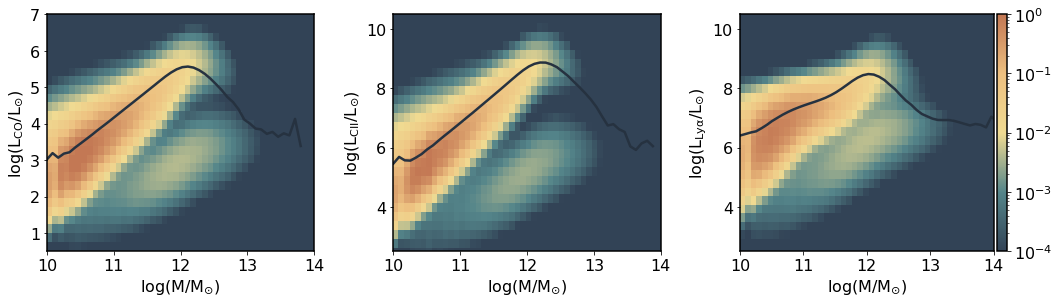

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4.5))

ax[0].hist2d(logMcat_CO, np.log10(LCO), bins=[50, 50], norm=mpl.colors.LogNorm(), 
                  cmap=cmap, density=True, vmin=1e-4, vmax=1)
ax[0].plot(logM[:-1], np.log10(meanLCO), color='#263240')
ax[0].set_facecolor(grey)
ax[0].set_ylim(0.5, 7)
ax[0].set_xlim(10, 14)
ax[0].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[0].set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
#ax0 = ax[0].twinx()
#ax0.plot(logM[:-1], meanLCO*(u.Lsun.to(u.erg/u.s)), alpha=0)

ax[1].hist2d(logMcat_CII, np.log10(LCII), bins=[50, 50], norm=mpl.colors.LogNorm(), 
             cmap=cmap, density=True, vmin=1e-4, vmax=1)
ax[1].plot(logM[:-1], np.log10(meanLCII), color='#263240')
ax[1].set_facecolor(grey)
ax[1].set_ylim(2.5, 10.5)
ax[1].set_xlim(10, 14)
ax[1].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[1].set_ylabel(r'$\log$(L$_{\rm CII}$/L$_{\odot}$)')


im=ax[2].hist2d(logMcat_Lya[LLya>0], np.log10(LLya[LLya>0]), bins=[50, 50], norm=mpl.colors.LogNorm(), 
             cmap=cmap, density=True, vmin=1e-4, vmax=1)
ax[2].plot(logM[:-1], np.log10(meanLLya), color='#263240')
ax[2].set_facecolor(grey)
ax[2].set_ylim(2.5, 10.5)
ax[2].set_xlim(10, 14)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='4%', pad=0.05)
fig.colorbar(im[3], cax=cax, orientation='vertical')
ax[2].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[2].set_ylabel(r'$\log$(L$_{\rm Ly\alpha}$/L$_{\odot}$)')

plt.tight_layout()

plt.savefig('/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/LM_2dhist.png', dpi=300)

In [3]:
nu_CO=115.271*u.GHz
zmin_CO = 2.4
zmax_CO = 3.4

CO=make_measurements(dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/',
                          lines=dict(CO=True),
                          target_line = 'CO',
                          models=dict(CO=dict(model_name='CO_Li16',
                                              model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                          do_external_SFR = False, external_SFR = '',
                          SFR_pars=dict(),
                          supersample=4,
                          mass=False,
                          Nmu=10,
                          dk=0.02*u.Mpc**-1,
                          zmin = zmin_CO-0.03, zmax = zmax_CO+0.03,
                          RAObs_min=0*u.deg,RAObs_max=1*u.deg,
                          DECObs_min=-0.5*u.deg,DECObs_max=0.5*u.deg,
                          RA_min=0*u.deg,RA_max=1*u.deg,
                          DEC_min=-0.5*u.deg,DEC_max=0.5*u.deg,
                          nuObs_max=nu_CO/(1+zmin_CO), nuObs_min=nu_CO/(1+zmax_CO),
                          beam_FWHM=4*u.arcmin,
                          dnu=100*u.MHz,
                          Tsys=0*u.K, 
                          Nfeeds=1000,
                          tobs=10000*u.hr,
                          linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                          do_smooth=True))

In [49]:
CO.update(dnu=4*31.25*u.MHz, beam_FWHM=4*u.arcmin, do_smooth=True)
CO_map=np.asarray(CO.obs_3d_map)

In [51]:
CO.update(dnu=4*31.25*u.MHz, beam_FWHM=4*u.arcmin, do_smooth=False, mass=True)
CO_map=np.asarray(CO.obs_3d_map)

In [32]:
CO.update(dnu=4*31.25*u.MHz, do_smooth=False)
CO_map2=np.asarray(CO.obs_3d_map)

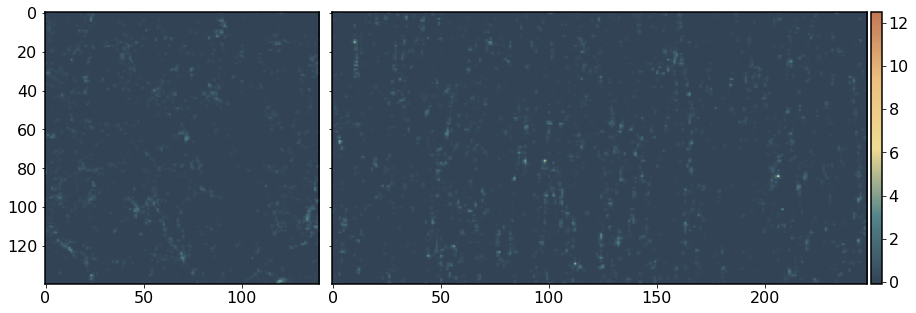

In [52]:
f, (a0, a1) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 2], 'wspace':0.03})

im0=a0.imshow(CO_map[0], cmap=cmap, vmin=np.min(CO_map), vmax=np.max(CO_map), aspect='auto')
im1=a1.imshow(CO_map[:, :, 50].T, cmap=cmap, vmin=np.min(CO_map), vmax=np.max(CO_map), aspect='auto')

a1.set_yticklabels([])
divider = make_axes_locatable(a1)
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
fig.tight_layout()

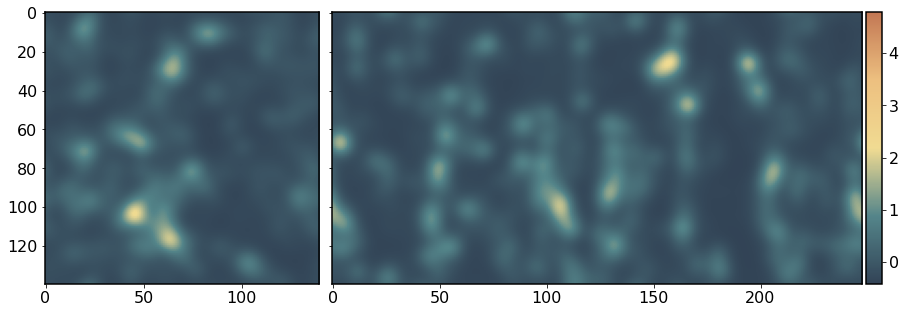

In [47]:
f, (a0, a1) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 2], 'wspace':0.03})

im0=a0.imshow(CO_map[0], cmap=cmap, vmin=np.min(CO_map), vmax=np.max(CO_map), aspect='auto')
im1=a1.imshow(CO_map[:, :, 50].T, cmap=cmap, vmin=np.min(CO_map), vmax=np.max(CO_map), aspect='auto')

a1.set_yticklabels([])
divider = make_axes_locatable(a1)
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
fig.tight_layout()
#plt.colorbar()

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


(array([1.20000e+01, 5.30000e+01, 4.28000e+02, 3.36100e+03, 2.32320e+04,
        1.08426e+05, 1.73542e+05, 7.62420e+04, 1.23360e+04, 4.17000e+02]),
 array([-5.5862308 , -4.709599  , -3.832967  , -2.9563353 , -2.0797036 ,
        -1.2030717 , -0.32643992,  0.5501919 ,  1.4268237 ,  2.3034556 ,
         3.1800873 ], dtype=float32),
 <BarContainer object of 10 artists>)

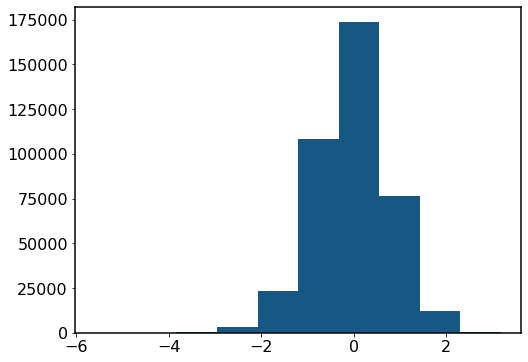

In [40]:
plt.hist(np.log10(CO_map2.flatten()))

## VID

In [80]:
def Gauss(x,mu,sig2):
    '''
    Gaussian PDF
    '''
    exparg = -0.5*x**2/sig2
    norm = (2.*np.pi*sig2)**0.5
    return np.exp(exparg)/norm

def Add_noise(T,Tout,PT,Pzero,sig2):
    '''
    Adds a noise PDF to a given PDF convoluting them
    
    params: 
    T: temperature vector
    PT: PDF of temperature
    Pzero: The value of P(T=0) (i.e., P(N=0))
    sig2: variance of the noise PDF
    '''
    conv = np.zeros(len(Tout))*PT.unit
    for i in range(len(Tout)):
        conv[i] = np.trapz(Gauss(Tout[i]-T,0.,sig2)*PT,T)
    conv += Pzero*Gauss(Tout,0.,sig2)
    
    return conv

def get_VID_T(M, NTbins):
    sig2 = M.sigma_N**2
    Nsigma = 7

    n0=int(1e6)
    tt2min=np.min([-Nsigma*sig2.value**0.5, -M.Tmean])
    TT2=np.concatenate((np.linspace(tt2min,0,n0)*M.T.unit,M.T))
    ind_mean=int(np.argmin(np.abs(TT2-M.Tmean)))
    PT=np.concatenate((np.concatenate((np.zeros(n0-(ind_mean-n0))*M.PT.unit,M.PT)), np.zeros(ind_mean-n0)*M.PT.unit))
    Toute = np.linspace(tt2min,M.Tedge[-1].value,2**8+1)*M.T.unit
    Tout = vut.binedge_to_binctr(Toute)

    PT_total = Add_noise(TT2,Tout,PT,M.PT_zero,sig2)
    print(len(PT_total), len(TT2), len(Tout), np.trapz(PT_total, Tout))

    Tmin_i,Tmax_i,nT_i = 0*u.K,10*u.K,NTbins
    Tbin_edge=np.linspace(Tmin_i, Tmax_i, nT_i+1)
    Tbin=(Tbin_edge[:-1]+Tbin_edge[1:])/2.

    Balpha_tot_overNvox = vut.pdf_to_histogram(Tout,PT_total,Tbin_edge,1,0.*Tbin.unit,0.)
    Balpha=Balpha_tot_overNvox*M.Nvox
    
    return Tbin, Balpha

def get_VID_I(M, NTbins):
    sig2 = ((M.sigma_N/np.sqrt(M.tpix*M.Nfeeds)).to(u.Jy/u.sr))**2
    Nsigma = 7

    n0=int(1e6)
    TT2min=np.min([-Nsigma*sig2.value**0.5, -M.Tmean.value])
    TT2=np.concatenate((np.linspace(TT2min,0,n0)*M.T.unit,M.T))
    ind_mean=int(np.argmin(np.abs(TT2-M.Tmean)))
    
    PT=np.concatenate((np.concatenate((np.zeros(n0-(ind_mean-n0))*M.PT.unit,M.PT)), np.zeros(ind_mean-n0)*M.PT.unit))
    Toute = np.linspace(TT2min,M.Tedge[-1].value,2**8+1)*M.T.unit
    Tout = vut.binedge_to_binctr(Toute)

    PT_total = Add_noise(TT2,Tout,PT,M.PT_zero,sig2)
    print(len(PT_total), len(TT2), len(Tout), np.trapz(PT_total, Tout))

    Tmin_i,Tmax_i,nT_i = -1e3*u.Jy/u.sr,6e4*u.Jy/u.sr,NTbins
    Tbin_edge=np.linspace(Tmin_i, Tmax_i, nT_i+1)
    Tbin=(Tbin_edge[:-1]+Tbin_edge[1:])/2.

    Balpha_tot_overNvox = vut.pdf_to_histogram(Tout,PT_total,Tbin_edge,1,0.*Tbin.unit,0.)
    Balpha=Balpha_tot_overNvox*M.Nvox
    
    return Tout, PT_total

In [75]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, sfr_pars, line):
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
    
    if line=='CO':
        nu=115.271*u.GHz
        Z=2.9
        DZ=1
        nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
        model_params = dict(nu=115.271*u.GHz, nuObs=nuObs, 
                            sigma_scatter=0.3,
                            hmf_model='Tinker', 
                            bias_model='Tinker10', 
                            model_type='ML',
                            Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                            model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file=SFR_file,sig_SFR=0.3),                     
                            model_name='TonyLi', 
                            do_onehalo=True, do_RSD=True, smooth=True, 
                            kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                            nk=512, nmu=10, 
                            Tmin_VID=1e-5*u.Jy/u.sr,Tmax_VID=500*u.Jy/u.sr,nT=2**21,
    #                        Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                            dndL_Lcut=10*u.Lsun,
                            do_Jysr=True)
        obs_params = dict(Delta_nu=Dnu, dnu=31.25*u.MHz,
                          #Tsys_NEFD=(45*u.K/(69.4)**0.5)*np.sqrt(4/400), #We get the improvement here as an efficient way
                          Tsys_NEFD=1e-5*u.Jy*u.s**(1./2),
                          Nfeeds=19*2,
                          beam_FWHM=4.5*u.arcmin,
                          tobs=1000*u.hr,
                          Omega_field=400*u.deg**2,
                          Nfield=1)    
        obs_params.update(model_params)
        obs_params.update(cosmo_fid)
    elif line=='CII':
        nu=1900.539*u.GHz
        Z=3
        DZ=1
        
        nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
        model_params = dict(nu=nu, nuObs=nuObs,
                            sigma_scatter=0.3,
                            hmf_model='Tinker', 
                            bias_model='Tinker10', 
                            model_type='ML',
                            Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                            model_name='SilvaCII',
                            model_par={'SFR_file':'Silva15_SFR_params.dat','a':1.,'b':6.9647}, 
                            do_onehalo=True, do_RSD=False, smooth=True, 
                            kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1,
                            nk=512, nmu=10, 
                            Tmin_VID=1e-5*u.Jy/u.sr,Tmax_VID=1e7*u.Jy/u.sr,nT=2**21,
    #                        Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e12*u.Lsun,Ngal_max=30,
                            dndL_Lcut=10*u.Lsun,
                            do_Jysr=True)
        obs_params = dict(Delta_nu=Dnu, dnu=0.938*u.GHz,
                          #Tsys_NEFD=(45*u.K/(69.4)**0.5)*np.sqrt(4/400), #We get the improvement here as an efficient way
                          Tsys_NEFD=1e-10*u.Jy*u.s**(1./2),
                          Nfeeds=30,
                          beam_FWHM=3*u.arcmin,
                          tobs=8*u.hr,
                          Omega_field=400*u.deg**2,
                          Nfield=1)    
        obs_params.update(model_params)
        obs_params.update(cosmo_fid)
    return obs_params

In [18]:
np.diff(np.log10(np.logspace(0, np.log10(np.max(CO_map)), 50+1)))

array([0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406,
       0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406,
       0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406,
       0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406,
       0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406,
       0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406,
       0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406,
       0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406, 0.0566406,
       0.0566406, 0.0566406])

In [20]:
#CO_map=np.load('../../map_noiseless_CO.npy')
#TiCO_edge=np.linspace(-1, 50, 50+1)

TiCO_pos=np.logspace(0, np.log10(np.max(CO_map)), 50+1)
TiCO_neg=-np.logspace(np.log10(np.max(CO_map)), 0, 50+1)
TiCO_edge=np.concatenate((TiCO_neg[TiCO_neg>=np.min(CO_map)],TiCO_pos))
TiCO=(TiCO_edge[:-1]+TiCO_edge[1:])/2.

BiCO_LC=np.histogram(CO_map.flatten(), bins=TiCO_edge)[0]

In [22]:
#CII_map=np.load('../../map_noiseless_CII.npy')

TiCII_pos=np.logspace(0, np.log10(np.max(CII_map)), 50+1)
TiCII_neg=-np.logspace(np.log10(np.max(CII_map)), 0, 50+1)
TiCII_edge=np.concatenate((TiCII_neg[TiCII_neg>=np.min(CII_map)],TiCII_pos))
TiCII=(TiCII_edge[:-1]+TiCII_edge[1:])/2.

#TiCII_edge=np.linspace(-1e3, 6e4, 50+1)
#TiCII=(TiCII_edge[:-1]+TiCII_edge[1:])/2.

BiCII_LC=np.histogram(CII_map.flatten(), bins=TiCII_edge)[0]

In [23]:
TiLya_pos=np.logspace(0, np.log10(np.max(Lya_map)), 50+1)
TiLya_neg=-np.logspace(np.log10(np.max(Lya_map)), 0, 50+1)
TiLya_edge=np.concatenate((TiLya_neg[TiLya_neg>=np.min(Lya_map)],TiLya_pos))
TiLya=(TiLya_edge[:-1]+TiLya_edge[1:])/2.

#TiLya_edge=np.linspace(-1, 50, 50+1)
#TiLya=(TiLya_edge[:-1]+TiLya_edge[1:])/2.

BiLya_LC=np.histogram(Lya_map.flatten(), bins=TiLya_edge)[0]

In [ ]:
grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'

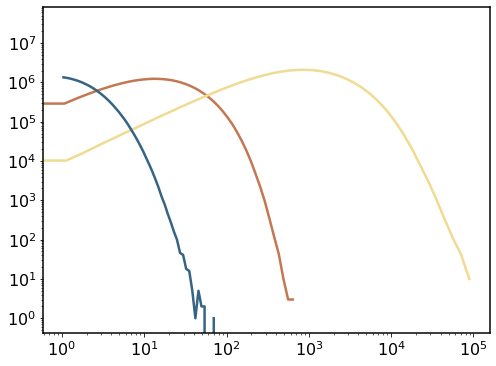

In [26]:
blue='#366485'
yellow='#f0db92'
orange='#C37854'
plt.plot(TiCO, BiCO_LC, color=orange)
plt.plot(TiCII, BiCII_LC, color=yellow)
plt.plot(TiLya, BiLya_LC, color=blue)

plt.xscale('log')
plt.yscale('log')

In [18]:
#Ii_edge=np.concatenate((-np.logspace(1.5, -2, 51),np.logspace(-2, 3, 51)))
#Ii=(Ii_edge[:-1]+Ii_edge[1:])/2.
Ii_edge=np.linspace(0, 400, 50)
Ii=(Ii_edge[:-1]+Ii_edge[1:])/2.

BiCO_LC=np.histogram(CO_map.flatten(), bins=Ii_edge)[0]

In [34]:
m_CO = lim(lim_params('/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat','other'))

TypeError: lim_params() missing 1 required positional argument: 'line'

In [12]:
m_CO.normalization

Note: redshifts have been re-sorted (earliest first)


<Quantity 0.99750512>

In [19]:
Ti_CO, Bi_lim=get_VID_I(m_CO, 50)

256 3097152 256 0.3893223331952085


In [48]:
print(LC_CO.sigmaN, m_CO.sigma_N)
print(LC_CO.Npix*LC_CO.Nchan, m_CO.Nvox)
print(np.sum(Bi_LC), np.sum(Bi_lim))

5.188291430328926 uK 5.188291430328926 uK
97412848 97412848.0
97218267 82218007.14324757


In [26]:
Ii_edge=np.linspace(-1e3, 6e4, 51)
Ii=(Ii_edge[:-1]+Ii_edge[1:])/2.

BiCII_LC=np.histogram(CII_map.flatten(), bins=Ii_edge)[0]

In [76]:
m_CII = lim(lim_params('/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat','other', 'CII'))

In [77]:
m_CII.normalization

Note: redshifts have been re-sorted (earliest first)


<Quantity 1.01352179>

In [50]:
Ii_CII, BiCII_lim=get_VID_I(m_CII, 50)

256 9388608 256 0.016810423491008697


In [78]:
Ttest, PTtest=get_VID_I(m_CII, 50)

8192 3097152 8192 -1.879519389846351e-10


In [58]:
sig2 = ((m_CII.sigma_N/np.sqrt(m_CII.tpix*m_CII.Nfeeds)).to(u.Jy/u.sr))**2

tt2min=np.min([-7*sig2.value**0.5, -m_CII.Tmean.value])
print(sig2, tt2min)

5443.391006629329 Jy2 / sr2 -1283.2496741908512


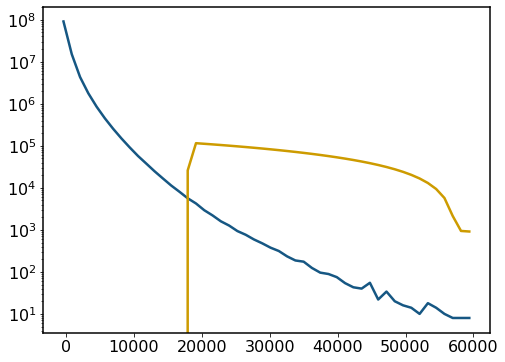

In [51]:
plt.plot(Ii, BiCII_LC)
plt.plot(Ii, BiCII_lim)
plt.yscale('log')

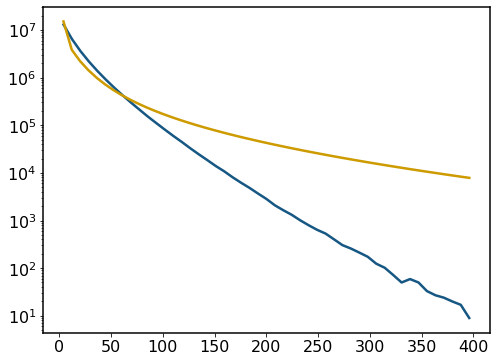

In [20]:
plt.plot(Ii, BiCO_LC)
plt.plot(Ti_CO, Bi_lim)
plt.yscale('log')

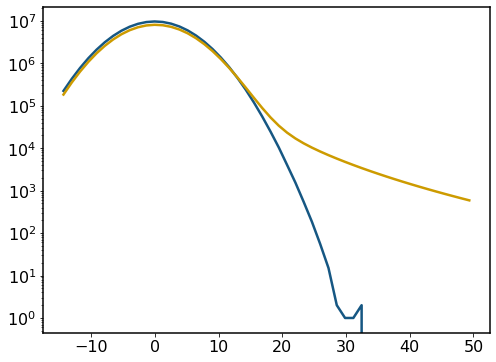

In [35]:
plt.plot(Ti, BiCO_LC)
plt.plot(Ti_CO, Bi_lim)
plt.yscale('log')

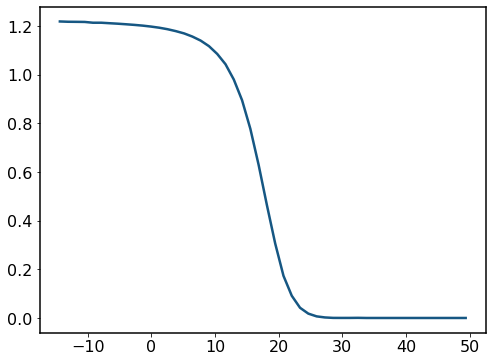

In [51]:
plt.plot(Ti, Bi_LC/Bi_lim)